In [2]:
!pip install ijson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.8/111.8 kB 4.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ijson
import re
from collections import defaultdict
import matplotlib.cm as cm

In [ ]:
# data = pd.read_json('ratebeer.json')
# !pip install ijson

0. Сбор/выгрузка данных

In [ ]:
def fix_json_file(input_file, output_file):
    with open(input_file, 'r') as f:
        lines = f.readlines()

    fixed_lines = []
    json_obj = ''

    for line in lines:
        line = line.strip()
        if line:
            json_obj += line
        else:
            fixed_lines.append(json_obj)
            json_obj = ''

    # Write the fixed JSON objects to the output file
    with open(output_file, 'w') as f:
        for line in fixed_lines:
            f.write(line + '\n')

json_file = 'ratebeer.json'
fixed_file ='ratebeer_fixed.json'

In [ ]:
fix_json_file(json_file, fixed_file)

In [ ]:
def count_lines(filename):
    with open(filename, 'r') as f:
        lines = 0
        for line in f:
            lines += 1
    return lines

total_lines = count_lines(json_file)
total_lines

In [ ]:
lines_to_load = int(total_lines * 0.1)
chunksize = int(lines_to_load / 10) + 1 #планирую загрузку в 10 чанков для 10% данных
lines_to_load, chunksize

In [ ]:
chunks_loaded = 0
data_frames = []

In [ ]:
json_file = 'ratebeer_fixed.json'
prefix = ''

In [ ]:
def load_chunk(chunk_size):
    records = []

    with open(json_file, 'r') as f:
        for i, line in enumerate(f):
            line = line.replace("'", '"')  # Replace single quotes with double quotes
            try:
                obj = json.loads(line)
                records.append(obj)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON object on line {i + 1}: {e}")

            if len(records) >= chunk_size:
                break

    return records

data_frames = []

# while True:
#     chunk_data = load_chunk(chunk_size)
#     if not chunk_data:
#         break
#     data_frames.append(pd.DataFrame(chunk_data))

# result_df = pd.concat(data_frames, ignore_index=True)

Json вообще не парсится - много проблем с обходом некорретного форматирования, решила решить проблему радикально:

In [ ]:
import random

with open('ratebeer.txt', 'r') as f:
    total_lines = f.read()

total_lines = total_lines.split('\n')
lines_to_load = int(len(total_lines) * 0.1)

In [ ]:
selected_lines = random.sample(total_lines, lines_to_load) # выгружаем только 10% данных
df = pd.DataFrame([eval(line) for line in selected_lines])

In [ ]:
#дата без пропусков
len(df.dropna(subset = 'review/profileName')), len(df)

(292416, 292416)

In [ ]:
df.columns = df.columns.str.replace('/', '_')

In [ ]:
df.columns

Index(['beer_name', 'beer_beerId', 'beer_brewerId', 'beer_ABV', 'beer_style',
       'review_appearance', 'review_aroma', 'review_palate', 'review_taste',
       'review_overall', 'review_time', 'review_profileName', 'review_text'],
      dtype='object')

1. EDA

In [ ]:
df.describe()

,beer_name,beer_beerId,beer_brewerId,beer_ABV,beer_style,review_appearance,review_aroma,review_palate,review_taste,review_overall,review_time,review_profileName,review_text
count,292416,292416,292416,292416,292416,292416,292416,292416,292416,292416,292416,292416,292416
unique,50501,50521,5829,488,89,5,10,5,10,20,4149,13009,291056
top,Pabst Blue Ribbon,734,32,5,India Pale Ale &#40;IPA&#41;,3/5,7/10,3/5,7/10,14/20,1188604800,Ungstrup,
freq,373,373,4732,25247,18505,127246,87000,138132,88600,43372,542,1557,516


In [ ]:
df.head(3)

,beer_name,beer_beerId,beer_brewerId,beer_ABV,beer_style,review_appearance,review_aroma,review_palate,review_taste,review_overall,review_time,review_profileName,review_text
0,Brewsters Claudia,5477,998,4.5,Wheat Ale,2/5,7/10,3/5,5/10,8/20,1060387200,BeerLimey,"(Cask GBBF): Dense cloudy amber appearance, cl..."
1,Lagunitas Cruising with Ruben and The Jets,96186,1167,8.6,Imperial Stout,3/5,7/10,4/5,8/10,16/20,1241222400,NJBeerman013,"22 oz bottle. Pours a muddy, dark brown in co..."
2,Dogfish Head Raison D Extra,12834,198,18.5,American Strong Ale,4/5,8/10,4/5,8/10,15/20,1139702400,Dorwart,"UPDATED: MAR 22, 2010 (2005) release. Thin li..."


In [ ]:
df['review_overall'] = df['review_overall'] .apply(lambda x: x.split('/')[0]).astype(int)

In [ ]:
# df['review_profileName'].value_counts()[:10]
#есть прям ценители пива

In [ ]:
top_reviewers = df.groupby('review_profileName')['review_overall'].agg(['count', 'mean']).sort_values(by='count', ascending=False)

print(top_reviewers.head(10))

                    count       mean
review_profileName                  
Ungstrup             1557  11.567759
fonefan              1548  12.125969
Papsoe               1445  11.855363
yespr                1338  12.355755
oh6gdx                974  11.737166
kp                    968  11.754132
omhper                940  11.160638
argo0                 841  12.583829
joergen               836  12.385167
Oakes                 832  11.778846


In [ ]:
df.groupby('review_profileName').size().mean()
#то есть в average user оставляем 22 отзыва, остальные - энтузиасты

22.477976785302484

In [ ]:
len(df.groupby('review_profileName').size()[df.groupby('review_profileName').size() > 22])

2302

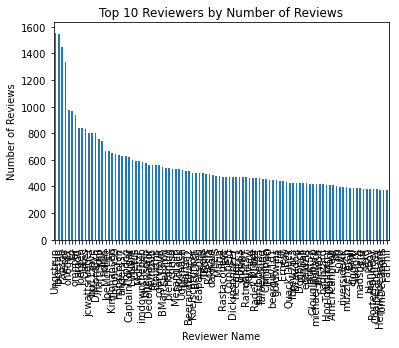

In [ ]:
top_reviewers['count'].head(100).plot(kind='bar')
plt.title('Top 10 Reviewers by Number of Reviews')
plt.xlabel('Reviewer Name')
plt.ylabel('Number of Reviews')
plt.show()

Резонно оставить юзером, которые оставили "адекватное" кол-во отзывов на товары - отсечем по среднему + 5%

In [ ]:
df['review_profileName'].value_counts()[df['review_profileName'].value_counts() < 100]

Niko100         99
jstraw          99
kassner         99
GranvilleTim    99
padrefan98      99
                ..
LadyLilith       1
dantheman99      1
WhitePony813     1
aequity          1
Jaybeatle        1
Name: review_profileName, Length: 12248, dtype: int64

In [ ]:
less_common_users = df['review_profileName'].value_counts() < 100
less_common_users = less_common_users[less_common_users].index
df = df[df['review_profileName'].isin(less_common_users)]

In [ ]:
df['beer_name'].value_counts()[:10]

Pabst Blue Ribbon                                  290
Guinness Draught                                   277
Sierra Nevada Pale Ale &#40;Bottle&#41;            263
Budweiser                                          253
North Coast Old Rasputin Russian Imperial Stout    246
Dogfish Head 90 Minute Imperial IPA                243
Newcastle Brown Ale                                234
Chimay Bleue &#40;Blue&#41; / Grande Rserve        234
Corona Extra                                       233
Heineken                                           225
Name: beer_name, dtype: int64

In [ ]:
# df.groupby(['beer_name']).review_overall.sum()

In [ ]:
top_rated_beers = df.groupby('beer_name')['review_overall'].mean().sort_values(ascending=False)
print(top_rated_beers.head(10))

beer_name
Diekirch Grand Cru Ambree                  20.0
Rosengarten Maisgold Spezial Bier          20.0
Zero Gravity DKinna Bock                   20.0
Stadtguet Beginner                         20.0
Franziskaner Hefe-Weissbier Alkoholfrei    20.0
Bastone Witface                            20.0
Samuel Adams Bitter                        20.0
John Shippeys Bootlegger Nut Brown Ale     20.0
Fredericksburg Hoppy Holidaze              20.0
Rhinelander Light                          20.0
Name: review_overall, dtype: float64


In [ ]:
counts = df.groupby('review_overall')['beer_name'].value_counts()
top_counts = counts.groupby(level=0).head(5)


top_counts = top_counts.unstack()
top_counts = top_counts.fillna(0)
top_counts = top_counts.sort_index(axis=1)

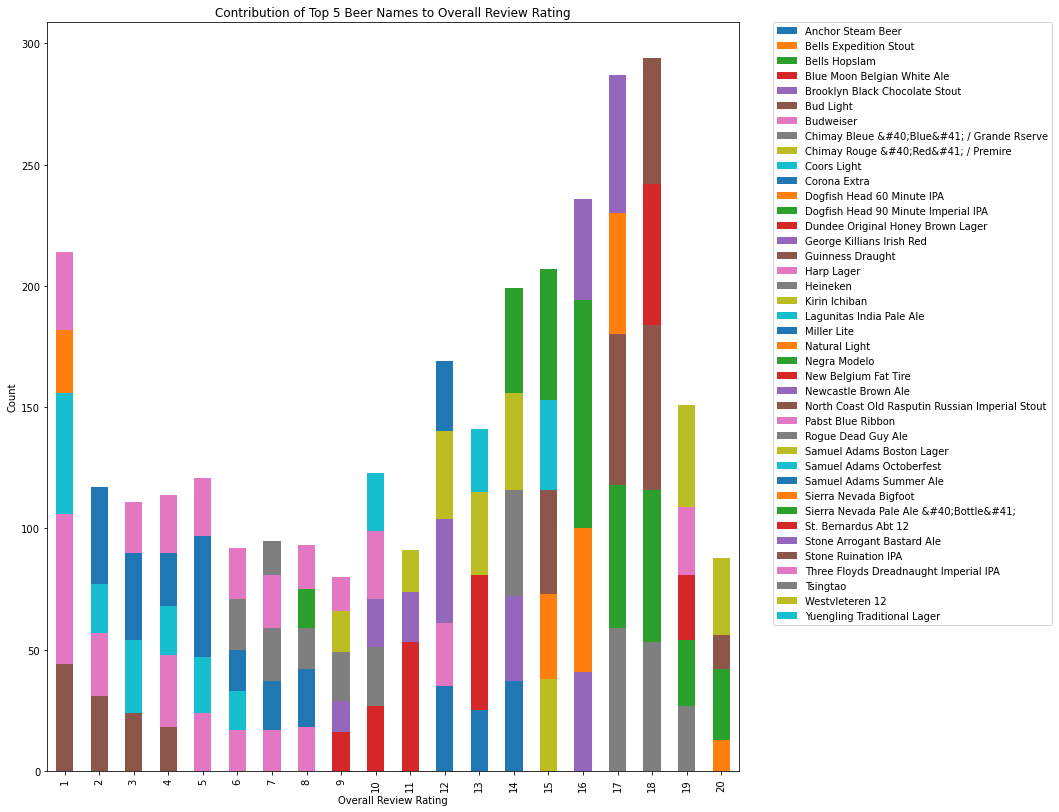

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
top_counts.plot(kind='bar', stacked=True, ax=ax)

plt.title('Contribution of Top 5 Beer Names to Overall Review Rating')
plt.xlabel('Overall Review Rating')
plt.ylabel('Count')

plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=1.5, wspace=0.4, hspace=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

График сложновато читать из-за обилия переменных, так как не все прокрашиваются в уникальными цветами. Но визуально нельзя сказать, что есть какой-то тренд по вкладу определного вида продукта в тот или иную оценку.

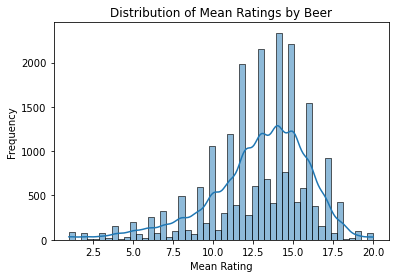

In [ ]:
# df.groupby('beer_name')['review_overall'].mean().hist(bins = 50)

mean_ratings = df.groupby('beer_name')['review_overall'].mean()
sns.histplot(data=mean_ratings, bins=50, kde=True)
plt.title('Distribution of Mean Ratings by Beer')
plt.xlabel('Mean Rating')
plt.ylabel('Frequency')

plt.show()

2. Transition Matrix

In [ ]:
print(df.shape)
df.columns

(117042, 13)


Index(['beer_name', 'beer_beerId', 'beer_brewerId', 'beer_ABV', 'beer_style',
       'review_appearance', 'review_aroma', 'review_palate', 'review_taste',
       'review_overall', 'review_time', 'review_profileName', 'review_text'],
      dtype='object')

In [ ]:
data = df[['beer_name', 'beer_beerId',
           'review_profileName','review_overall']].rename({'beer_name': 'item_name',
                                                           'beer_beerId': 'item_id',
                                                          'review_profileName': 'user_name',
                                                          'review_overall' : 'rating'}, axis = 1)

In [ ]:
import networkx as nx

In [ ]:
G = nx.Graph()

In [ ]:
# G.add_nodes_from(data_for_plot['item_id'].unique())
# for user, item_group in data_for_plot.groupby('user_name'):
#     item_group = item_group['item_id']
#     for item1, item2 in zip(item_group, item_group.shift(-1).dropna()):
#         if not G.has_edge(item1, item2):
#             G.add_edge(item1, item2, weight=1)
#         else:
#             G[item1][item2]['weight'] += 1

In [ ]:
# pos = nx.spring_layout(G)

# edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
# nx.draw_networkx_nodes(G, pos, node_size=10, node_color='lightblue')
# nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.4)
# nx.draw_networkx_labels(G, pos, font_size=6, font_family='sans-serif')

# plt.axis('off')
# plt.show()

Поскольку мы работаем с данными юзер-продукт, то логично рассматривать информацию в виде двудольного графа. Попробуем для небольшого семпла:

In [ ]:
# data_for_plot = data.sample(10)

In [ ]:
user_nodes = data['user_name'].unique()
item_nodes = data['item_id'].unique()
G.add_nodes_from(user_nodes, bipartite=0)
G.add_nodes_from(item_nodes, bipartite=1)
for user, item, rating in zip(data['user_name'], data['item_id'], data['rating']):
    G.add_edge(user, item, weight=rating)

# pos = nx.spring_layout(G)

# edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
# nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_size=2, node_color='lightblue')
# nx.draw_networkx_nodes(G, pos, nodelist=item_nodes, node_size=2, node_color='lightcoral')
# nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.4)
# nx.draw_networkx_labels(G, pos, font_size=6, font_family='sans-serif')

# plt.axis('off')
# plt.show()

nx.write_gexf(G, 'graph.gexf')

In [ ]:
G_copy = G.copy()
train_edges = random.sample(list(G_copy.edges()), int(len(G_copy.edges())*0.8))

G_test = G_copy.copy()
G_test.remove_edges_from(train_edges)

# Calculating PageRank on the training set
train_df = pd.DataFrame(train_edges, columns=['user_name', 'item_id'])
train_df['rating'] = [G[u][v]['weight'] for u, v in train_edges]

# Calculating PageRank on the testing set
test_df = pd.DataFrame(G_test.edges(), columns=['user_name', 'item_id'])
test_df['rating'] = [G_test[u][v]['weight'] for u, v in G_test.edges()]

In [ ]:
train_df.shape

(93400, 3)

In [ ]:
test_df.shape

(23351, 3)

In [ ]:
data.to_csv('beer_ratings_preproc_data.csv', index = False)

In [ ]:
train_df.to_csv('beer_ratings_train.csv', index = False)

In [ ]:
train_df.to_csv('beer_ratings_test.csv', index = False)

## PageRank и LightGCN

In [4]:
from sklearn import preprocessing as pp

In [5]:
data = pd.read_csv('beer_ratings_preproc_data.csv', sep = ',')

In [6]:
data

,item_name,item_id,user_name,rating
0,Lagunitas Cruising with Ruben and The Jets,96186,NJBeerman013,16
1,Red Duck Limited Release SWB,61351,Lunkie,11
2,Tequiza,481,Zach Diesel,1
3,Full Sail Top Sail Imperial Porter Bourbon Bar...,83949,timfoolery,19
4,Samuel Smiths Imperial Stout,85,judasbeer,14
...,...,...,...,...
117037,Smuttynose IPA,32134,ElJefe,17
117038,Unibroue La Fin du Monde,1094,Slacks,16
117039,Hoegaarden,399,happy4hops,13
117040,Two Hearted Ale,1502,LetsGoState,13


In [7]:
user_encoder = pp.LabelEncoder()
data['user_id'] = user_encoder.fit_transform(data['user_name'].values)

## Personalized PageRank

In [8]:
!pip install recmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from matplotlib import cm
import seaborn as sns
import networkx as nx

from sklearn.model_selection import train_test_split
from networkx.algorithms import bipartite
from tqdm import tqdm
import matplotlib.pyplot as plt
import recmetrics

In [11]:
train, test = train_test_split(data, test_size=0.2, random_state=42)


edges = []
users = set()
items = set()
for index, row in train.iterrows():
    user, item = row["user_id"] + 1000000, row["item_id"] # чтобы не было пересечений в айдишниках сделаем шифт у юзеров
    edges.append((user, item, row["rating"]))
    users.add(user)
    items.add(item)


user_item_graph_train = nx.Graph()
user_item_graph_train.add_nodes_from(list(users) + list(items))
user_item_graph_train.add_weighted_edges_from(edges)
item_item_graph_train = bipartite.weighted_projected_graph(user_item_graph_train, list(items), ratio=True)

In [12]:
print(f"Кол-во юзеров: {len(users)}")
print(f"Кол-во объектов: {len(items)}")

Кол-во юзеров: 11184
Кол-во объектов: 19820


In [13]:
class PersonalizedPageRankRecSys:
    def __init__(self, user_movie_graph, movie_movie_graph, movies):
        self.user_movie_graph = user_movie_graph
        self.movie_movie_graph = movie_movie_graph
        self.movies = movies

    def create_preference_vector(self, user_id):
        if user_id not in self.user_movie_graph.nodes():
            return None

        edges = {m: w for _, m, w in self.user_movie_graph.edges(user_id, data="weight")}
        total = sum(edges.values())

        if total > 0:
            return {movie: edges.get(movie, 0) / total for movie in self.movies}
        else:
            return {movie: 1 for movie in self.movies}

    def recommend(self, user_id):
        p_vec = self.create_preference_vector(user_id)

        if p_vec is None:
            pr = nx.pagerank(self.movie_movie_graph)
        else:
            pr = nx.pagerank(self.movie_movie_graph, personalization=p_vec)

        sorted_nodes = sorted(pr.items(), key=lambda x: x[1], reverse=True)

        if p_vec is None:
            recommended_nodes = [(node, score) for node, score in sorted_nodes]
        else:
            recommended_nodes = [(node, score) for node, score in sorted_nodes if node not in self.user_movie_graph[user_id]]

        return recommended_nodes



def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.

    This function computes the average prescision at k between two lists of
    items.

    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists

    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.

    This function computes the mean average prescision at k between two lists
    of lists of items.

    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The mean average precision at k over the input lists

    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [14]:
recsys = PersonalizedPageRankRecSys(user_item_graph_train, item_item_graph_train, items)

In [15]:
users_items_test = dict()

for index, row in test.iterrows():
    user, item = row["user_id"] + 1000000, row["item_id"] # чтобы не было пересечений в айдишниках сделаем шифт у юзеров
    if user in users_items_test:
        users_items_test[user].append(item)
    else:
        users_items_test[user] = [item]

In [ ]:
users_items_pred = dict()
users_to_predict = [user + 1000000 for user in train["user_id"].value_counts().index.tolist() if user + 1000000 in list(users_items_test.keys())][:100]

for user in tqdm(users_to_predict):
    users_items_pred[user] = recsys.recommend(user)[:100]

100%|██████████| 100/100 [10:11<00:00,  6.11s/it]


In [ ]:
MAP = []
MAR = []

for k in range(1, 100):
    y_true = []
    y_pred = []
    for user in users_to_predict:
        true = users_items_test[user]
        pred = [p[0] for p in users_items_pred[user]][:k]

        y_true.append(true)
        y_pred.append(pred)

    MAR.append(recmetrics.mark(y_true, y_pred, k = k))
    MAP.append(mapk(y_true, y_pred, k = k))

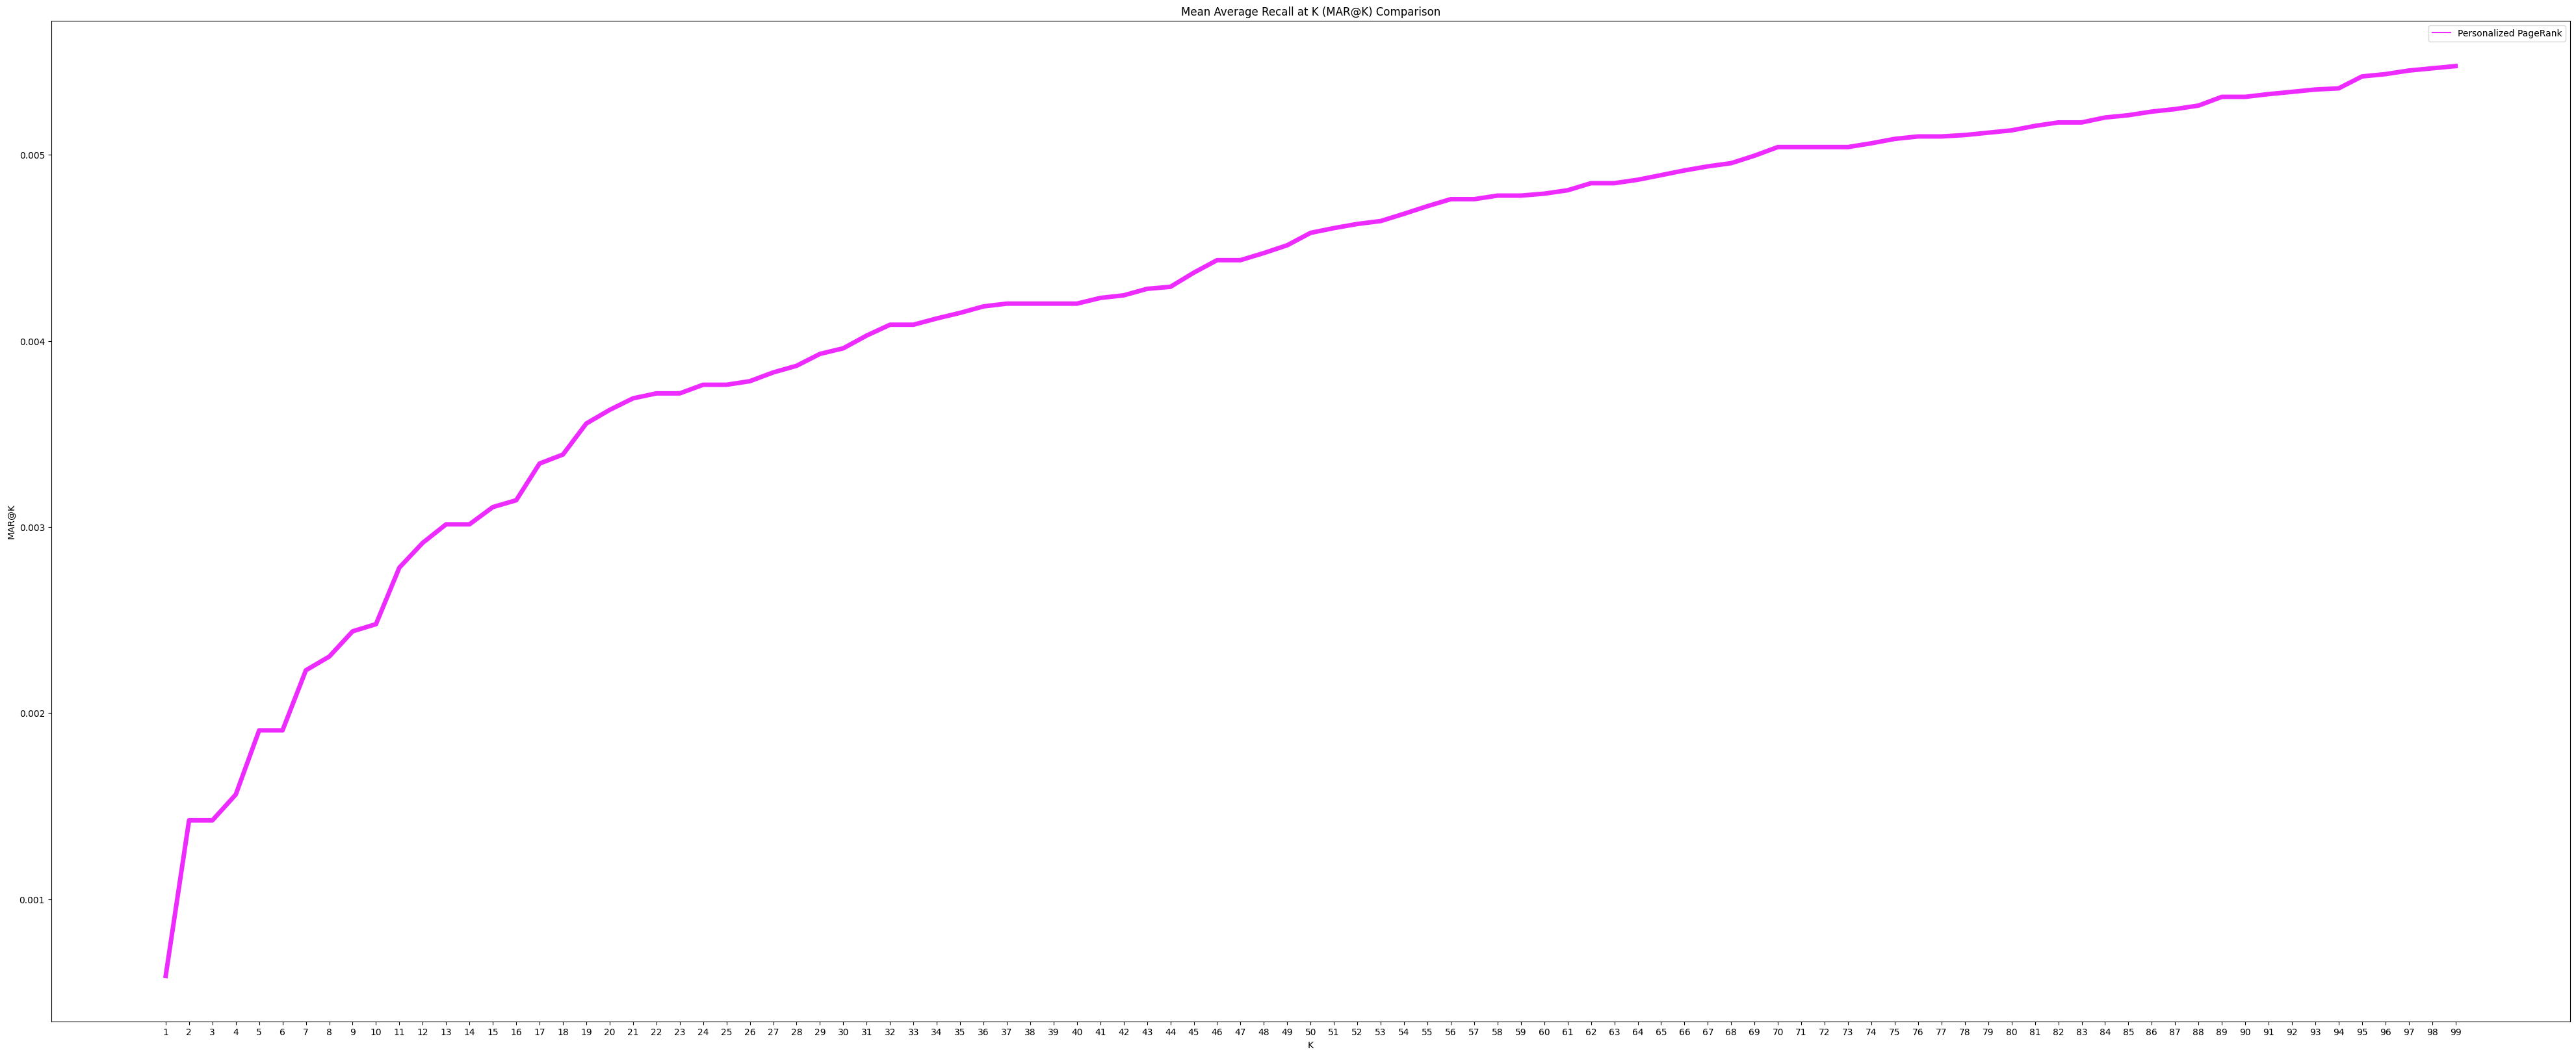

In [ ]:
plt.figure(figsize=(50, 20))
recmetrics.mark_plot([MAR], ["Personalized PageRank"], range(1, 100))

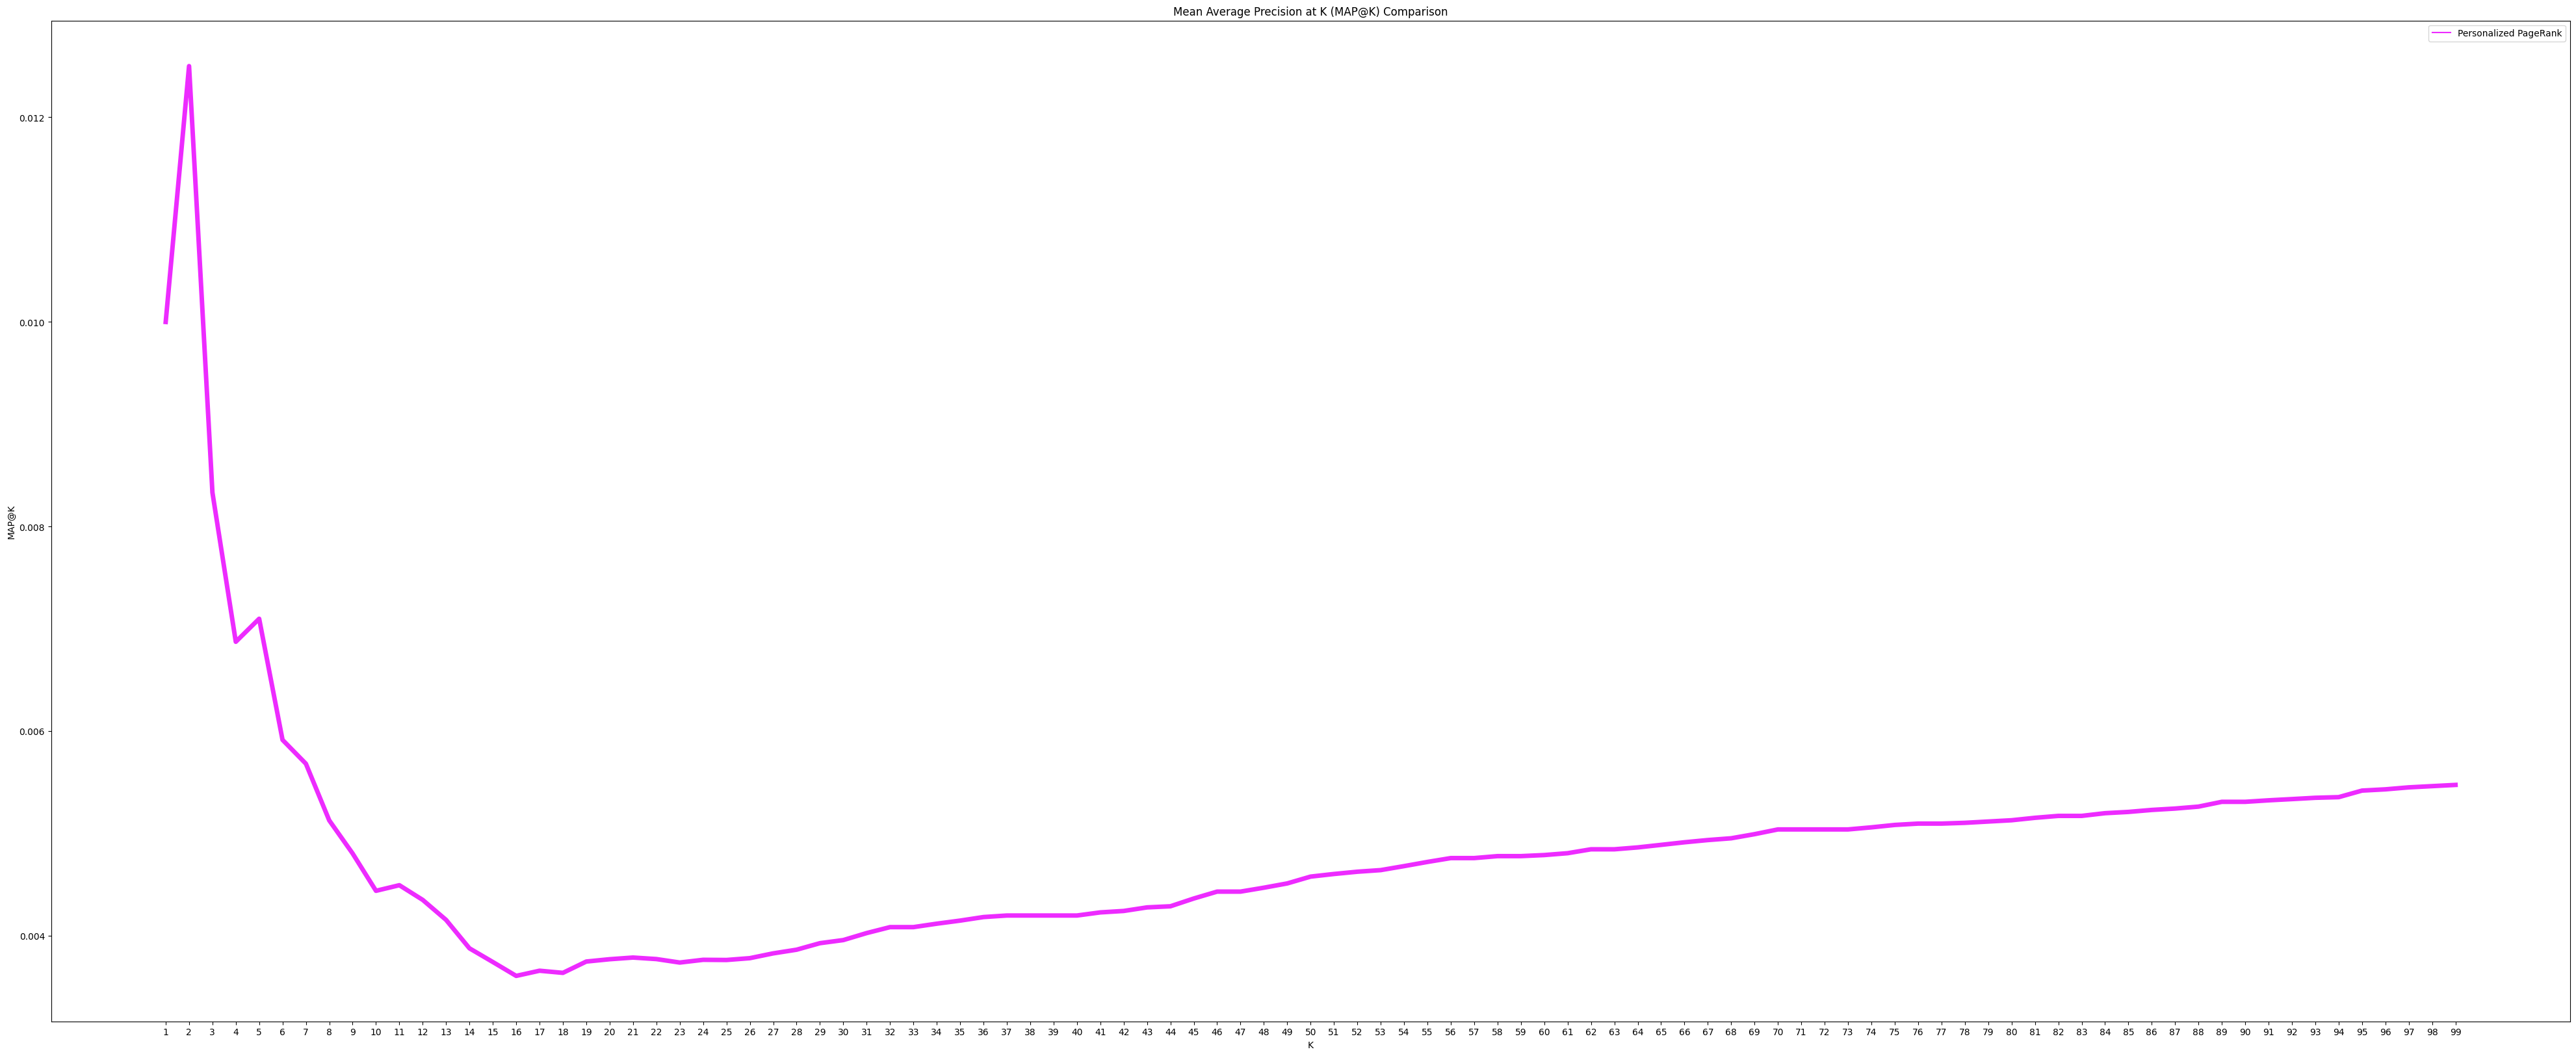

In [ ]:
plt.figure(figsize=(50, 20))
recmetrics.mapk_plot([MAP], ["Personalized PageRank"], range(1, 100))

## LightGCN

In [16]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.9 MB/s eta 0:00:00


In [17]:
import random
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [19]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train['user_id_idx'] = le_user.fit_transform(train['user_id'].values)
train['item_id_idx'] = le_item.fit_transform(train['item_id'].values)

In [20]:
train_user_ids = train['user_id'].unique()
train_item_ids = train['item_id'].unique()

test = test[
  (test['user_id'].isin(train_user_ids)) & \
  (test['item_id'].isin(train_item_ids))
]

In [21]:
test['user_id_idx'] = le_user.transform(test['user_id'].values)
test['item_id_idx'] = le_item.transform(test['item_id'].values)

In [22]:
n_users = train['user_id_idx'].nunique()
n_items = train['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  11184
Number of unique Items :  19820


In [23]:
u_t = torch.LongTensor(train.user_id_idx.to_numpy())
i_t = torch.LongTensor(train.item_id_idx.to_numpy()) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[10048,   953,  9485,  ..., 15430, 18169, 21924],
        [11375, 11535, 23050,  ...,  9995,  2781,   123]], device='cuda:0')

In [24]:
def data_loader(data, batch_size, n_usr, n_itm):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items)).to(device) + n_usr,
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )


class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):
    super().__init__(aggr='add')

  def forward(self, x, edge_index):
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j


class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim,
      num_layers,
      num_users,
      num_items,
  ):
    super(RecSysGNN, self).__init__()

    self.embedding = nn.Embedding(num_users + num_items, latent_dim)
    self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))
    self.init_parameters()


  def init_parameters(self):
    nn.init.normal_(self.embedding.weight, std=0.1)


  def forward(self, edge_index):
    emb0 = self.embedding.weight
    embs = [emb0]

    emb = emb0
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    out = (
      torch.mean(torch.stack(embs, dim=0), dim=0)
    )

    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users],
        out[pos_items],
        out[neg_items],
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )


def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) +
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))

  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

  return bpr_loss, reg_loss


def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
  test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

  relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

  i = torch.stack((
    torch.LongTensor(train['user_id_idx'].values),
    torch.LongTensor(train['item_id_idx'].values)
  ))
  v = torch.ones((len(train)), dtype=torch.float64)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)

  relevance_score = torch.mul(relevance_score, (1 - interactions_t))

  topk_relevance_indices = torch.topk(relevance_score, K).indices
  topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
  topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

  test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
  metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
  metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

  metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
  metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

  return metrics_df['recall'].mean(), metrics_df['precision'].mean()


def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(len(train)/BATCH_SIZE)

      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []

      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          test_topK_recall,  test_topK_precision = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test, K
          )

      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))

  return (
    loss_list_epoch,
    bpr_loss_list_epoch,
    reg_loss_list_epoch,
    recall_list,
    precision_list
  )

In [57]:
latent_dim = 64
n_layers = 3

EPOCHS = 10
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 20

In [58]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)

In [59]:
light_loss, light_bpr, light_reg, light_recall, light_precision = train_and_eval(lightgcn, optimizer, train)

  0%|          | 0/10 [00:00<?, ?it/s]

In [62]:
epoch_list = [(i+1) for i in range(EPOCHS)]

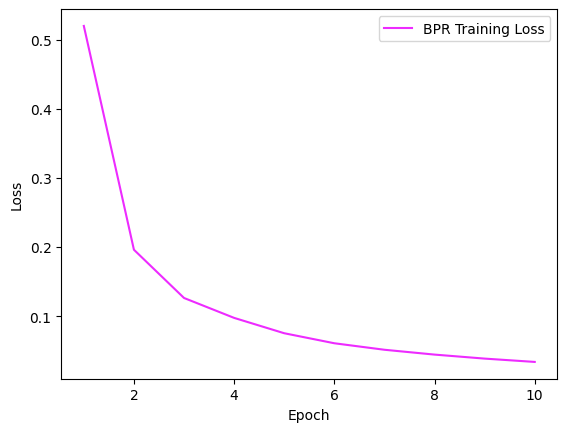

In [63]:
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

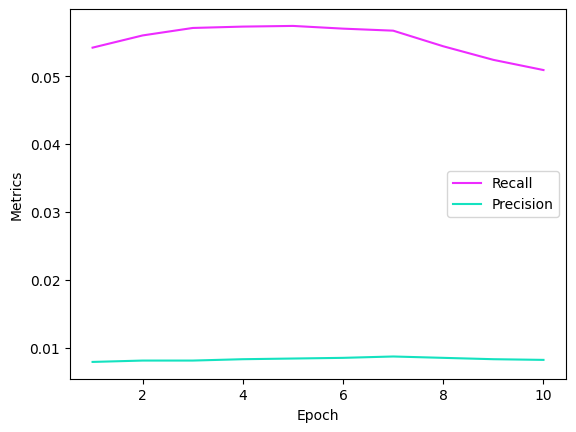

In [64]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

In [65]:
def get_preds(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
  test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
  relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

  i = torch.stack((
    torch.LongTensor(train['user_id_idx'].values),
    torch.LongTensor(train['item_id_idx'].values)
  ))
  v = torch.ones((len(train)), dtype=torch.float64)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)

  relevance_score = torch.mul(relevance_score, (1 - interactions_t))

  topk_relevance_indices = torch.topk(relevance_score, K).indices
  topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
  topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

  test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
  return pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])

In [66]:
_, out = lightgcn(train_edge_index)
final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
preds = get_preds(final_user_Embed, final_item_Embed, n_users, n_items, train, test, 100)

In [67]:
users_to_predict = [user for user in train["user_id_idx"].value_counts().index.tolist() if user in list(test['user_id_idx'])][:100]

In [68]:
MAP = []
MAR = []

for k in range(1, 100):
    y_true = []
    y_pred = []
    for user in users_to_predict:
        true = list(preds[preds["user_id_idx"] == user]["item_id_idx"])[0]
        pred = list(preds[preds["user_id_idx"] == user]["top_rlvnt_itm"])[0][:k]
    #     true = users_movies_test[user]
    #     pred = [p[0] for p in users_movies_pred[user]][:k]
        y_true.append(true)
        y_pred.append(pred)

    MAR.append(recmetrics.mark(y_true, y_pred, k = k))
    MAP.append(mapk(y_true, y_pred, k = k))

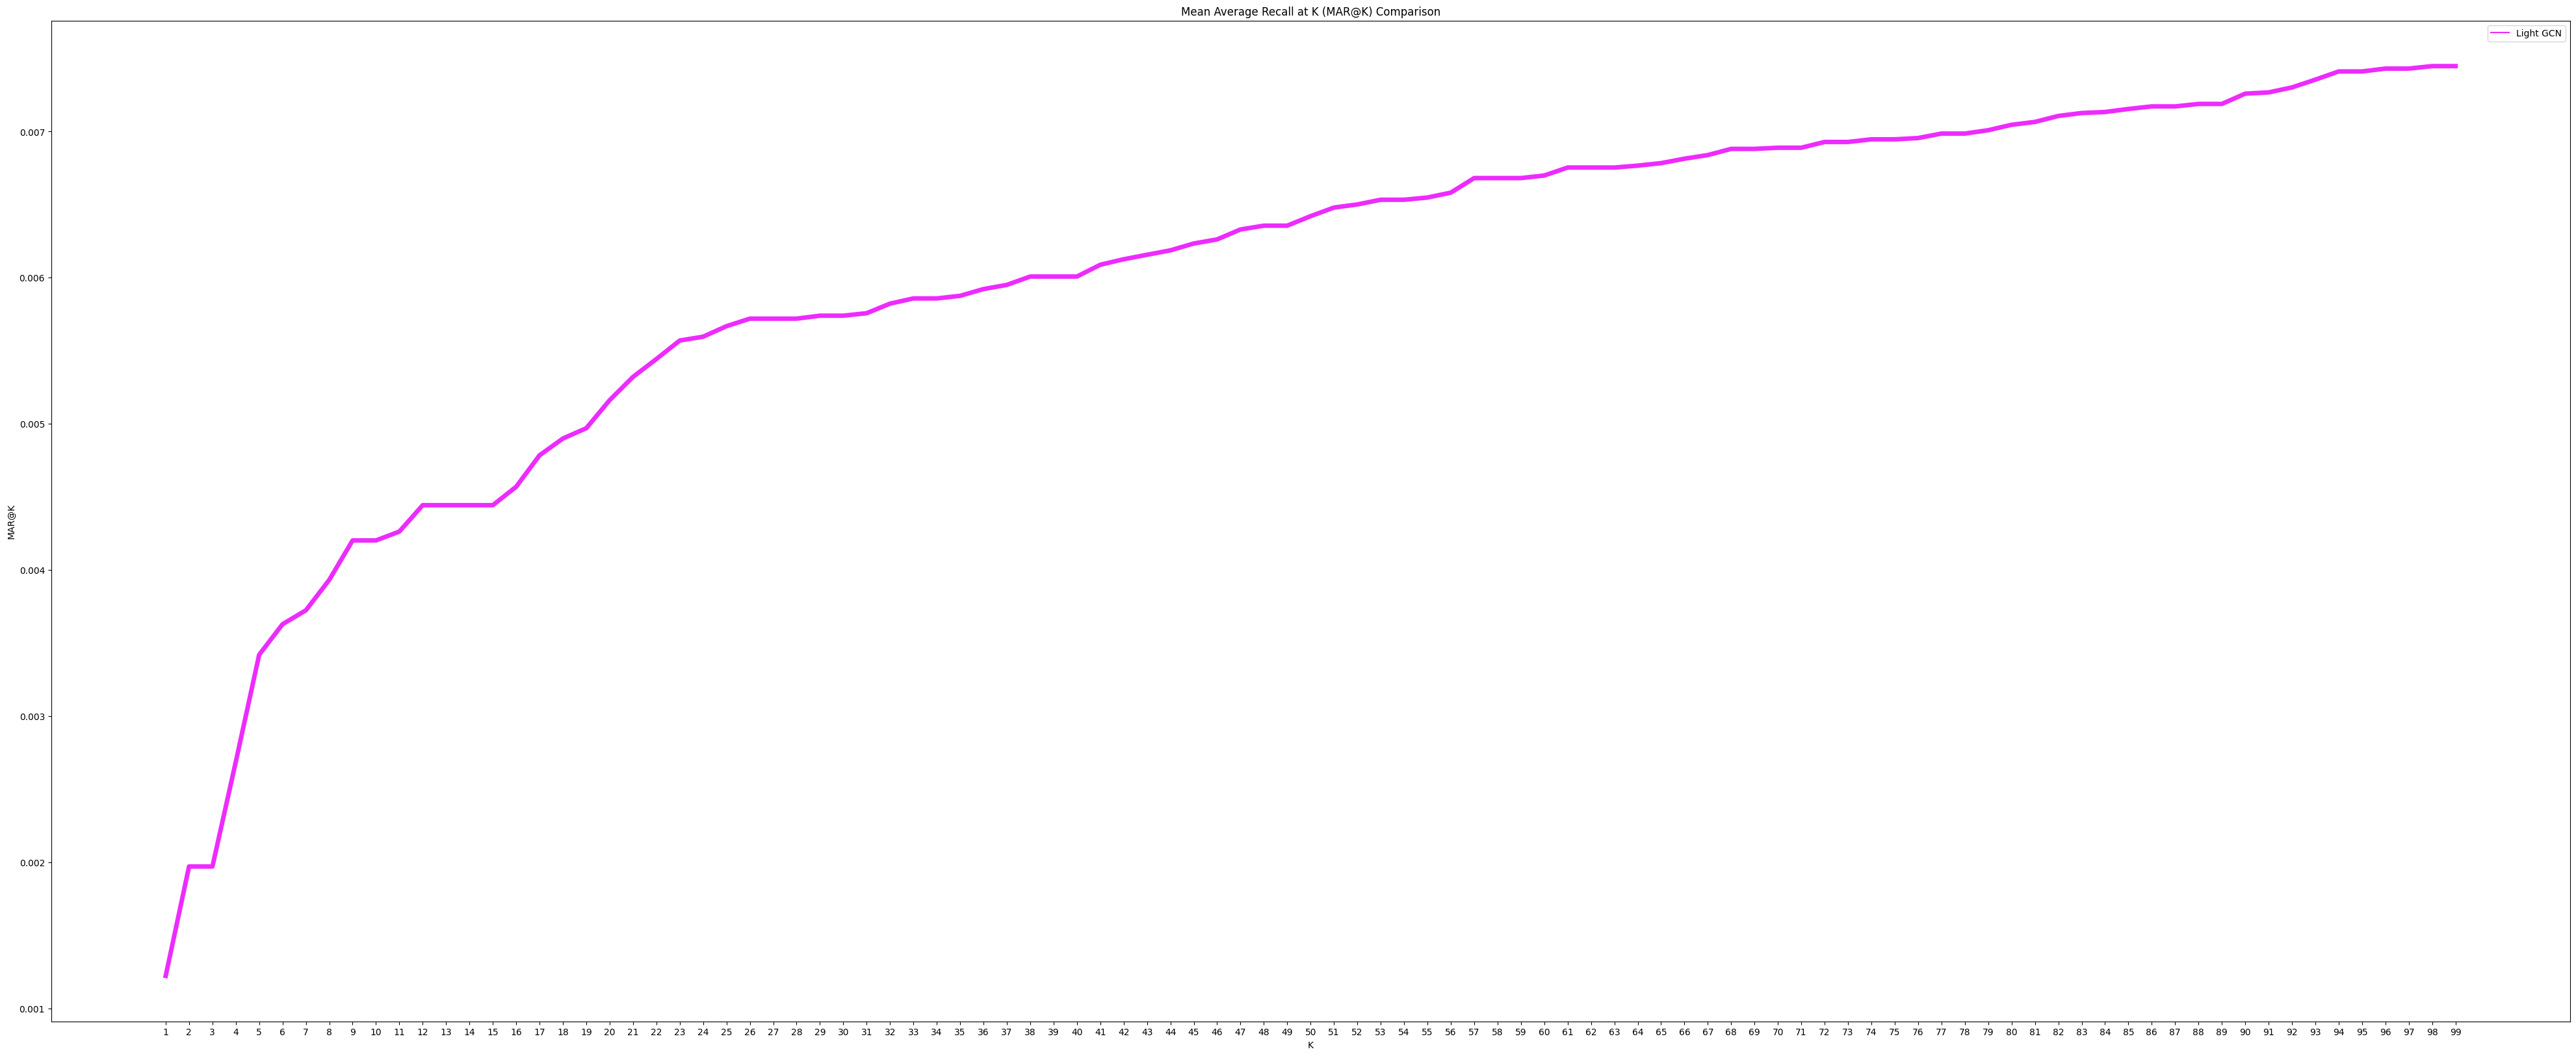

In [69]:
plt.figure(figsize=(50, 20))
recmetrics.mark_plot([MAR], ["Light GCN"], range(1, 100))

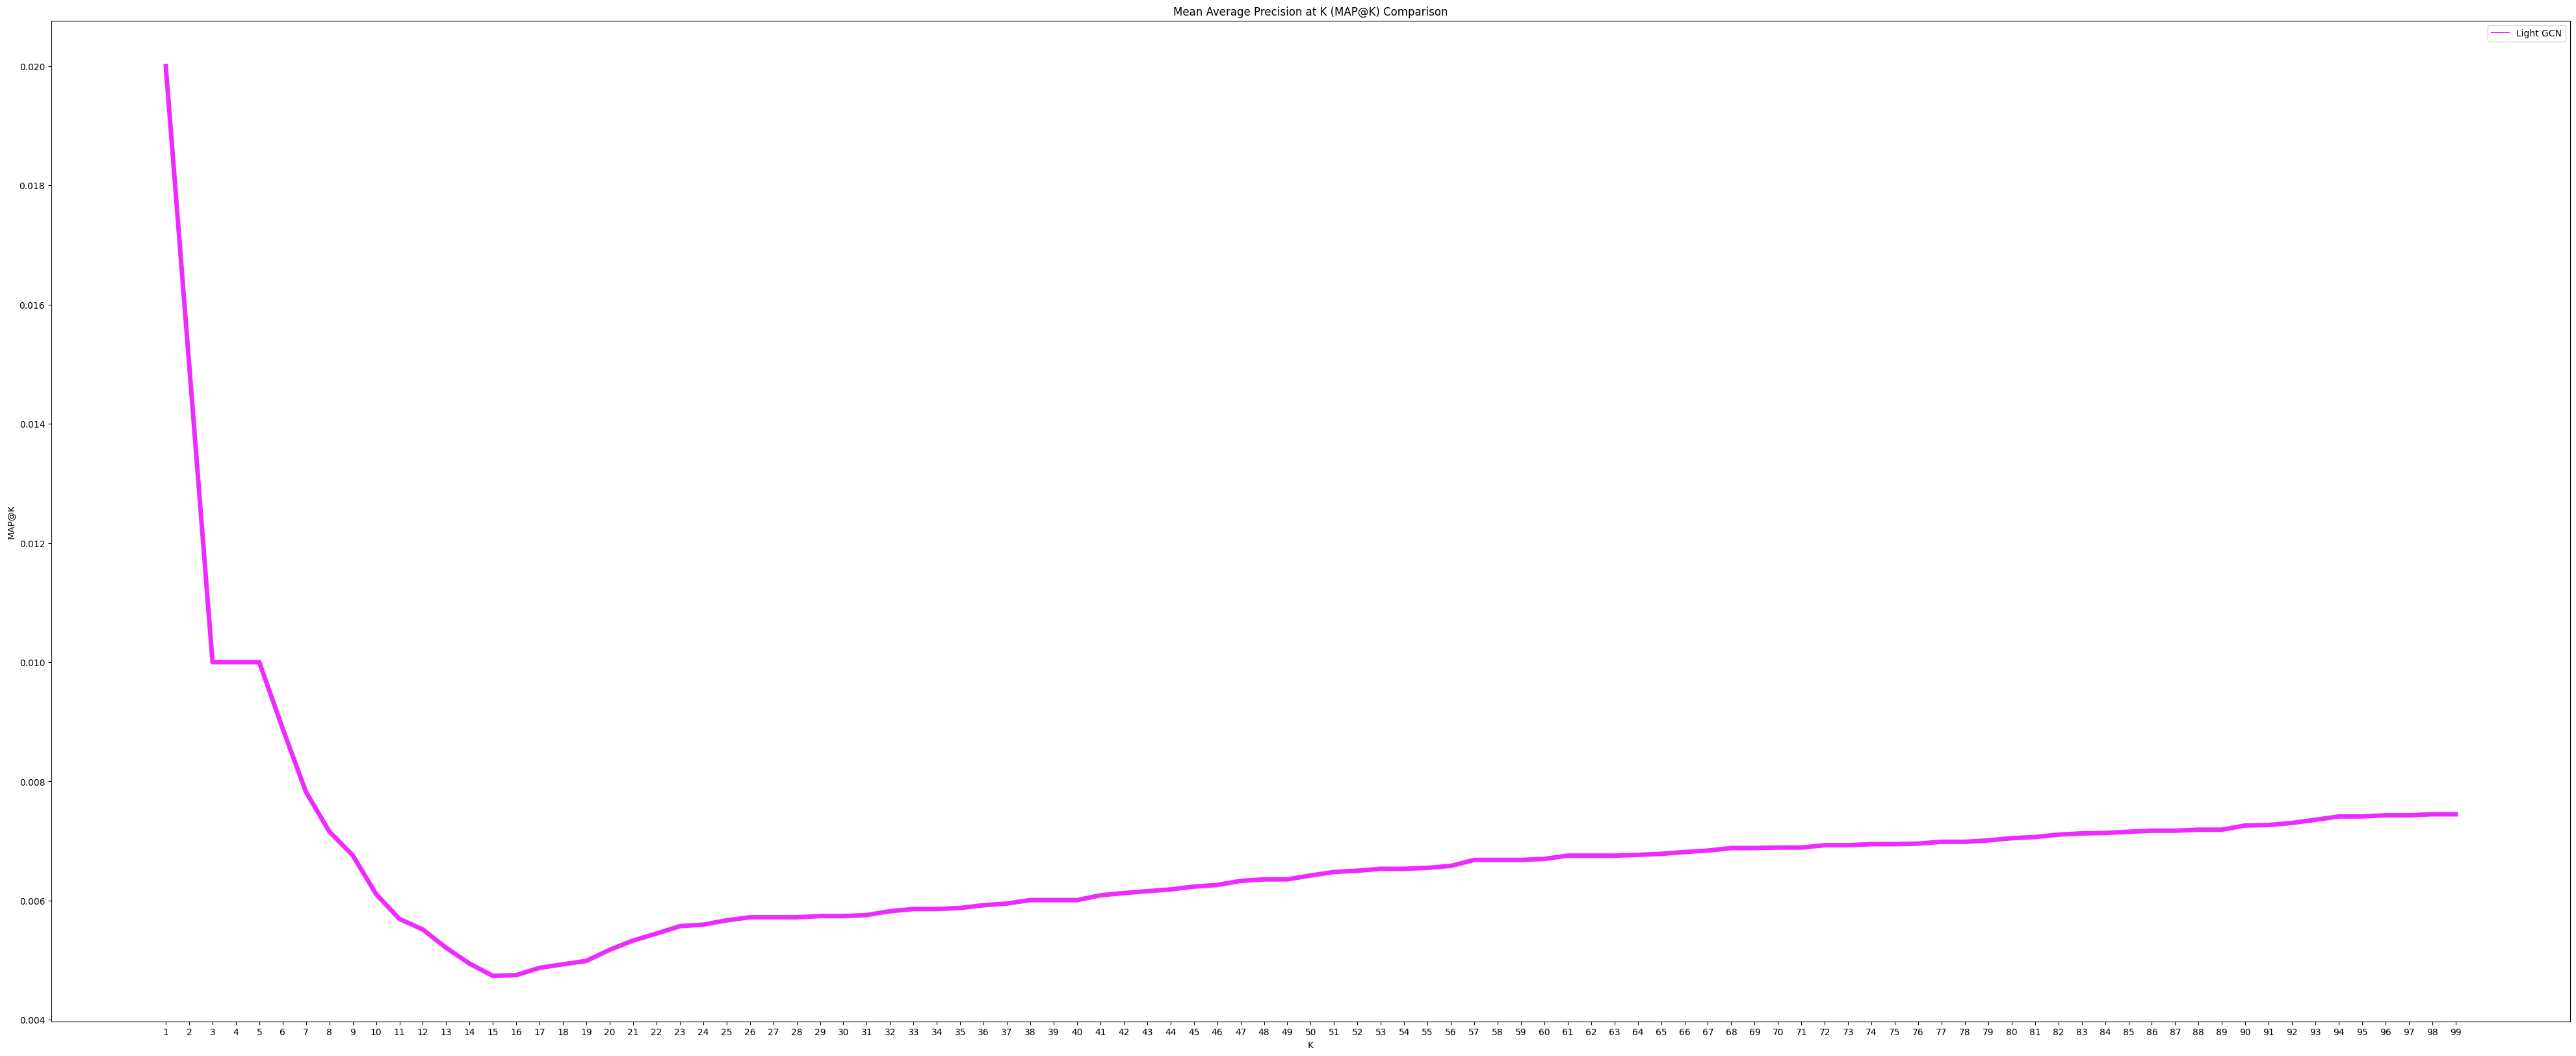

In [70]:
plt.figure(figsize=(50, 20))
recmetrics.mapk_plot([MAP], ["Light GCN"], range(1, 100))